In [1]:
import pandas as pd
import numpy as np
import json
import codecs
import re
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem.snowball import RussianStemmer
from nltk.tokenize import ToktokTokenizer
import preprocessing_tools as pr
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.model_selection import cross_val_score,KFold
from razdel import tokenize # pip install razdel # https://github.com/natasha/razdel
import pymorphy2 # pip install pymorphy2
morph = pymorphy2.MorphAnalyzer()

## Два класса: positive, negative

## Три класса: positive, neutral, negative

In [4]:
train = pd.read_json('train.json',encoding = 'UTF-8')
# Заменяем позитивный маркер на 1, негативный на -1, нейтральный на 0
labels = train['sentiment']
train['sentiment'] = train['sentiment'].replace(['positive' ,'neutral','negative'],[1,0,-1])
# задаем целевую переменную
target = train['sentiment']


In [6]:
print(len(train))
print(len(train[train.sentiment == 1]))
print(len(train[train.sentiment == -1]))
print(len(train[train.sentiment == 0]))

8263
2795
1434
4034


In [5]:
test_data = pd.read_json('test.json',encoding = 'UTF-8')

In [7]:
%reload_ext autoreload
train['text'] = train['text'].apply(pr.clean_text)
test_data['text'] = test_data['text'].apply(pr.clean_text)
train['lemmas'] = train['text'].apply(pr.lemmatization)
test_data['lemmas'] = test_data['text'].apply(pr.lemmatization)

In [8]:
train['lemmas'] = train['lemmas'].apply(str)
test_data['lemmas'] = test_data['text'].apply(str)

## Модель

### Naive Bayes

In [16]:
%%time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split

tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2),encoding='cp1251', 
                                   stop_words=stopwords.words('russian'))
#ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2))
tfidf_vectorizer.fit(train['lemmas'])
#ngram_vectorizer.fit(train['text'])
X = tfidf_vectorizer.transform(train['lemmas'])

X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.66
)

for alpha in [0.0001, 0.001, 0.01, 0.05, 0.25, 0.45, 0.5]:
    
    Multi_NB = MultinomialNB(alpha=alpha)
    Multi_NB.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (alpha, accuracy_score(y_val, Multi_NB.predict(X_val))))
    
    
final_Multi_NB = MultinomialNB(alpha = 0.01)
final_Multi_NB.fit(X_train, y_train)
print ("Final Accuracy: %s" 
       % accuracy_score(y_val, final_Multi_NB.predict(X_val)))
#print (metrics.classification_report(y_val,final_svm_tfidf.predict(X_val)))
print (classification_report(y_val,final_Multi_NB.predict(X_val), digits = 4))

C:\MyPrograms\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Accuracy for C=0.0001: 0.7103202846975089
Accuracy for C=0.001: 0.7145907473309608
Accuracy for C=0.01: 0.7074733096085409
Accuracy for C=0.05: 0.7053380782918149
Accuracy for C=0.25: 0.694306049822064
Accuracy for C=0.45: 0.6814946619217082
Accuracy for C=0.5: 0.6786476868327402
Final Accuracy: 0.7074733096085409
              precision    recall  f1-score   support

          -1     0.6699    0.7084    0.6886       487
           0     0.7406    0.6797    0.7088      1386
           1     0.6852    0.7481    0.7153       937

   micro avg     0.7075    0.7075    0.7075      2810
   macro avg     0.6986    0.7121    0.7042      2810
weighted avg     0.7099    0.7075    0.7075      2810

Wall time: 18.3 s


### Grid search NB

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

text_clf = Pipeline([('vectorizer', TfidfVectorizer()),
                     ('clf', MultinomialNB())])

tuned_parameters = {
    'vectorizer__ngram_range': [ (1, 2), (2, 2)],
    #'vectorizer__use_idf': (True, False),
    'vectorizer__sublinear_tf': (True, False),
    'vectorizer__norm': ('l1', 'l2'),
    'clf__alpha': [1, 1e-1, 1e-2]
}

In [38]:
x_train, x_test, y_train, y_test = train_test_split(train['lemmas'], target, test_size=0.33, random_state=42)

In [39]:
%%time
from sklearn.metrics import classification_report

score = 'f1_macro'
print("# Tuning hyper-parameters for %s" % score)
print()
np.errstate(divide='ignore')
clf = GridSearchCV(text_clf, tuned_parameters, cv=10, scoring=score)
clf.fit(x_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
for mean, std, params in zip(clf.cv_results_['mean_test_score'], 
                             clf.cv_results_['std_test_score'], 
                             clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
print(classification_report(y_test, clf.predict(x_test), digits=4))
print()

# Tuning hyper-parameters for f1_macro



C:\MyPrograms\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\MyPrograms\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\MyPrograms\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\MyPrograms\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\MyPrograms\Anaconda3\lib\site-packages\sklearn\metrics\classi

C:\MyPrograms\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\MyPrograms\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\MyPrograms\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\MyPrograms\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\MyPrograms\Anaconda3\lib\site-packages\sklearn\metrics\classi

C:\MyPrograms\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\MyPrograms\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\MyPrograms\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\MyPrograms\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\MyPrograms\Anaconda3\lib\site-packages\sklearn\metrics\classi

Best parameters set found on development set:

{'clf__alpha': 0.01, 'vectorizer__ngram_range': (1, 2), 'vectorizer__norm': 'l2', 'vectorizer__sublinear_tf': True}

Grid scores on development set:

0.219 (+/-0.000) for {'clf__alpha': 1, 'vectorizer__ngram_range': (1, 2), 'vectorizer__norm': 'l1', 'vectorizer__sublinear_tf': True}
0.219 (+/-0.000) for {'clf__alpha': 1, 'vectorizer__ngram_range': (1, 2), 'vectorizer__norm': 'l1', 'vectorizer__sublinear_tf': False}
0.411 (+/-0.047) for {'clf__alpha': 1, 'vectorizer__ngram_range': (1, 2), 'vectorizer__norm': 'l2', 'vectorizer__sublinear_tf': True}
0.403 (+/-0.050) for {'clf__alpha': 1, 'vectorizer__ngram_range': (1, 2), 'vectorizer__norm': 'l2', 'vectorizer__sublinear_tf': False}
0.219 (+/-0.000) for {'clf__alpha': 1, 'vectorizer__ngram_range': (2, 2), 'vectorizer__norm': 'l1', 'vectorizer__sublinear_tf': True}
0.219 (+/-0.000) for {'clf__alpha': 1, 'vectorizer__ngram_range': (2, 2), 'vectorizer__norm': 'l1', 'vectorizer__sublinear_tf': Fal

# Визуализация признаков 

## Без предобработки

In [5]:
from yellowbrick.text.freqdist import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
docs = vectorizer.fit_transform(train['text'])
features = vectorizer.get_feature_names()
visualizer = FreqDistVisualizer(features=features, n= 10, orient = 'v', size=(1080, 720))
visualizer.fit(docs)
visualizer.poof()

<Figure size 1080x720 with 1 Axes>

## С предобработкой

In [4]:
# убираем стоп-слова, чтобы визуализировать
train_vis = train['text'].apply(pr.clean_text)
train_vis = train['text'].apply(pr.stop_words_remove)

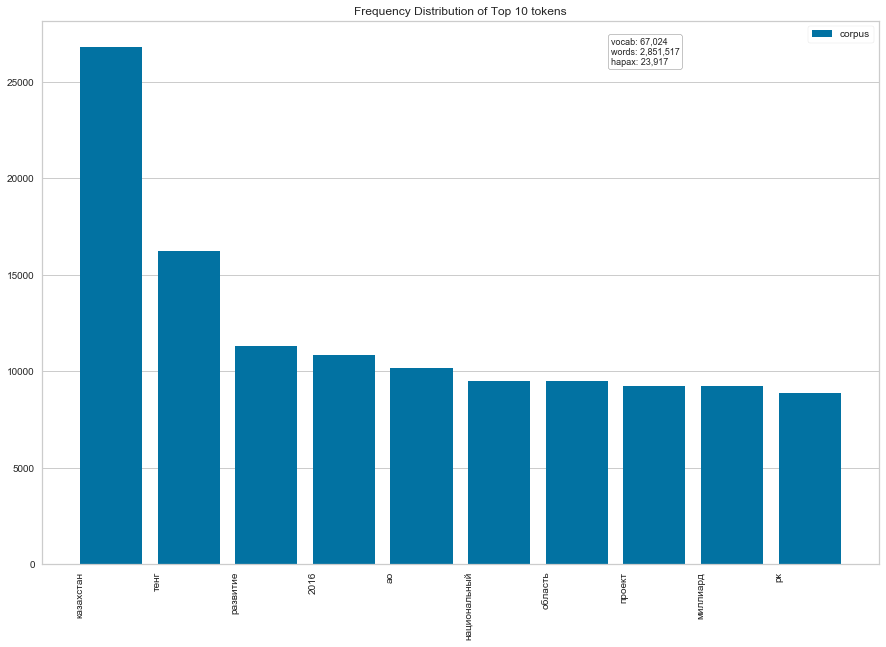

In [16]:
vectorizer = CountVectorizer(stop_words=stopwords.words('russian'))
docs = vectorizer.fit_transform(train_vis)
features = vectorizer.get_feature_names()
visualizer = FreqDistVisualizer(features=features, n= 10, orient = 'v', size=(1080, 720))
visualizer.fit(docs)
visualizer.poof()

In [5]:
with open('train.json',encoding = 'UTF-8') as f:
    raw_train = json.load(f)
with open('test.json',encoding = 'UTF-8') as f:
    raw_test = json.load(f)

In [6]:
all_texts = []
all_sentiment = []
all_sentiments = []
for i in raw_train:
    text = list(i.values())[0]
    all_texts.append(text)
    sentiment = list(i.values())[2]
    all_sentiment.append(sentiment)
    all_sentiments.append(sentiment)

In [7]:
all_texts = []
for i in raw_train:
    all_texts.append(i['text'].lower())

In [8]:
toktok = ToktokTokenizer()
stemmer = RussianStemmer()

processed_text = []

for line in all_texts:
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    no_punc = regex.sub('', line)
    no_num = re.sub(r'[A-Za-z0-9]+', '', no_punc)
    tokenized = toktok.tokenize(no_num)
    stemmed_str = ''
    for i in tokenized:
        stemmed = stemmer.stem(i)
        stemmed_str += str(stemmed + ' ')
    processed_text.append(stemmed_str)
    

In [31]:
%%time
from sklearn.metrics import accuracy_score,classification_report
# точность может варьироваться в зависимости от того, как произошло рабиение на обучающую и тестовую выборки
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2),encoding='cp1251')
tfidf_vectorizer.fit(processed_text)

X = tfidf_vectorizer.transform(processed_text)
X_lemmas = tfidf_vectorizer.transform(processed_text)
X_train, X_test, y_train, y_test = train_test_split(
    X_lemmas, target, train_size = 0.75, random_state = 1
)

cross_val_scale = []
mean_cross_val_scale =[]

partition_generator = KFold(n_splits=5, shuffle=True, random_state=42)


for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c,multi_class = 'ovr')
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_test, lr.predict(X_test))))
    cross_val_result = cross_val_score(lr, X_lemmas, target, cv=partition_generator)
        #составляем массив из средних арифметиеских кросс валидации c масштабированием признаков
    cross_val_scale.append(cross_val_result)
    mean_cross_val_scale.append(np.mean(cross_val_result))
    print(max(mean_cross_val_scale))
    
final_tfidf_lr = LogisticRegression(C=1, multi_class = 'ovr')
final_tfidf_lr.fit(X_train, y_train)
print ("Final Accuracy: %s" 
       % accuracy_score(y_test, final_tfidf_lr.predict(X_test)))
print (classification_report(y_test,final_tfidf_lr.predict(X_test)))

Accuracy for C=0.01: 0.4903194578896418
0.48820041043579143
Accuracy for C=0.05: 0.5091965150048403
0.5081695325397069
Accuracy for C=0.25: 0.6577928363988383
0.660048279670538
Accuracy for C=0.5: 0.6878025169409487
0.6898200351843957
Accuracy for C=1: 0.7047434656340755
0.7064002056573344
Final Accuracy: 0.7047434656340755
              precision    recall  f1-score   support

          -1       0.78      0.43      0.56       350
           0       0.67      0.83      0.74      1013
           1       0.74      0.66      0.70       703

   micro avg       0.70      0.70      0.70      2066
   macro avg       0.73      0.64      0.67      2066
weighted avg       0.71      0.70      0.70      2066

Wall time: 1min 8s


In [34]:
%%time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2),encoding='cp1251', 
                                   stop_words=stopwords.words('russian'))
#ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2))
tfidf_vectorizer.fit(processed_text)
#ngram_vectorizer.fit(train['text'])
X = tfidf_vectorizer.transform(processed_text)

X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.66
)

for c in [0.01, 0.05, 0.25, 0.45, 0.5, 0.55, 1]:
    
    svm = LinearSVC(C=c)
    svm.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, svm.predict(X_val))))
    
    
final_svm_tfidf = LinearSVC(C=0.45, multi_class = 'ovr')
final_svm_tfidf.fit(X_train, y_train)
print ("Final Accuracy: %s" 
       % accuracy_score(y_val, final_svm_tfidf.predict(X_val)))
#print (metrics.classification_report(y_val,final_svm_tfidf.predict(X_val)))
print (classification_report(y_val,final_svm_tfidf.predict(X_val), digits = 4))

Accuracy for C=0.01: 0.5380782918149466
Accuracy for C=0.05: 0.6711743772241993
Accuracy for C=0.25: 0.7096085409252669
Accuracy for C=0.45: 0.7106761565836299
Accuracy for C=0.5: 0.708185053380783
Accuracy for C=0.55: 0.7092526690391459
Accuracy for C=1: 0.7106761565836299
Final Accuracy: 0.7106761565836299
              precision    recall  f1-score   support

          -1     0.7494    0.5895    0.6599       497
           0     0.6979    0.7682    0.7313      1359
           1     0.7151    0.6918    0.7032       954

   micro avg     0.7107    0.7107    0.7107      2810
   macro avg     0.7208    0.6832    0.6982      2810
weighted avg     0.7128    0.7107    0.7092      2810

Wall time: 22.4 s


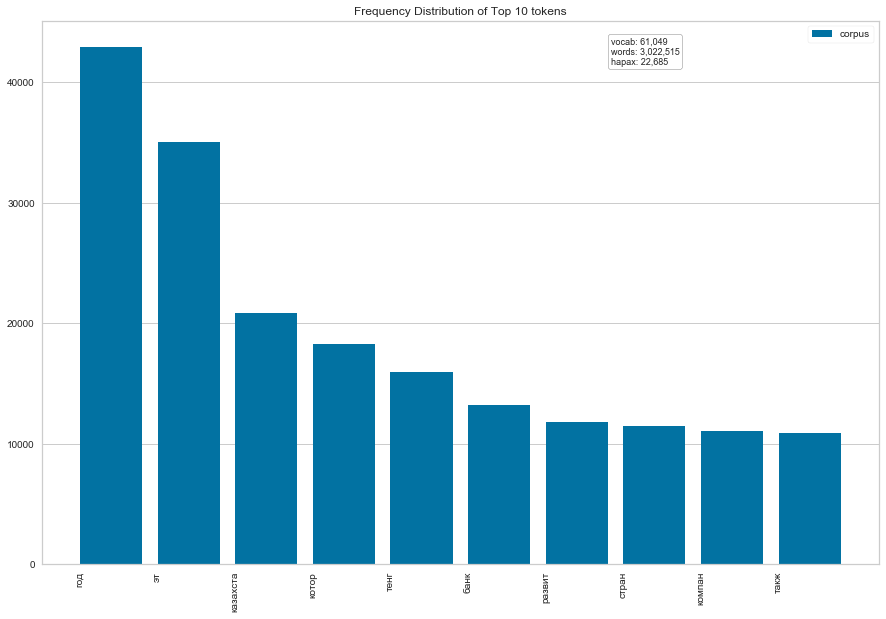

In [15]:
vectorizer = CountVectorizer(stop_words=stopwords.words('russian'))
docs = vectorizer.fit_transform(processed_text)
features = vectorizer.get_feature_names()
visualizer = FreqDistVisualizer(features=features, n= 10, orient = 'v', size=(1080, 720))
visualizer.fit(docs)
visualizer.poof()

In [9]:
toktok = ToktokTokenizer()
stemmer = RussianStemmer()
morph = pymorphy2.MorphAnalyzer()

all_texts_train = []
for i in raw_train:
    all_texts_train.append(i['text'].lower())

processed_text = []

for line in all_texts:
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    no_punc = regex.sub('', line)
    no_num = re.sub(r'[A-Za-z0-9]+', '', no_punc)
    tokenized = toktok.tokenize(no_num)
    stemmed_str = ''
    for i in tokenized:
        #stemmed = stemmer.stem(i) morph.parse(w)[0].normal_form
        stemmed = morph.parse(i)[0].normal_form
        stemmed_str += str(stemmed + ' ')
    processed_text.append(stemmed_str)
    

In [10]:
vectorizer = CountVectorizer(stop_words=stopwords.words('russian'))
docs = vectorizer.fit_transform(processed_text)
features = vectorizer.get_feature_names()
visualizer = FreqDistVisualizer(features=features, n= 10, orient = 'v', size=(1080, 720))
visualizer.fit(docs)
visualizer.poof()

NameError: name 'CountVectorizer' is not defined

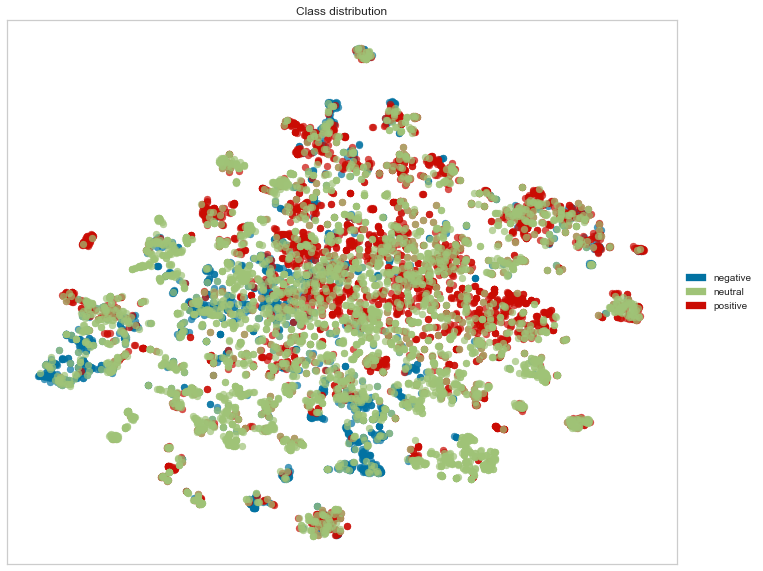

In [14]:
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
docs = tfidf.fit_transform(processed_text) 
labels = labels
tsne = TSNEVisualizer(title = 'Class distribution',size = (1080,720))
tsne.fit(docs, labels)
tsne.poof()